In [1]:
import torchOptics.optics as tt
import warnings
import torch
warnings.filterwarnings('ignore') ## ignore warnings
torch.cuda.empty_cache()  # GPU 캐시 메모리 비우기


/usr/local/lib/python3.8/dist-packages/kornia/feature/lightglue.py:30: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
!nvidia-smi

Mon Nov 18 12:30:13 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.01             Driver Version: 535.216.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        On  | 00000000:41:00.0 Off |                  Off |
| 42%   25C    P8              21W / 450W |      1MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
import torch
torch.cuda.empty_cache()


In [3]:
meta = {'wl':(638e-9, 515e-9, 450e-9), 'dx': (6.3e-6, 6.3e-6)} # 메타데이터 설정 # RGB 채널의 파장 값 (638nm, 515nm, 450nm) # 샘플링 간격 (픽셀 크기, 단위: 미터)
timg = tt.imread('/nfs/dataset/DIV2K/DIV2K_train_HR/DIV2K_train_HR/0250.png', meta=meta)  
# 고해상도 이미지를 읽어와 Tensor로 변환
# '/nfs/dataset/DIV2K/DIV2K_train_HR/DIV2K_train_HR/0250.png' 경로의 이미지를 읽어들임
# meta: 메타데이터를 포함하여 이미지 정보를 설정


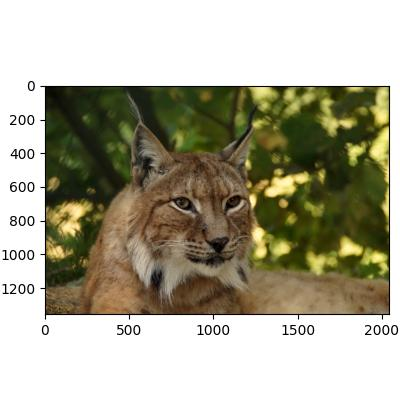
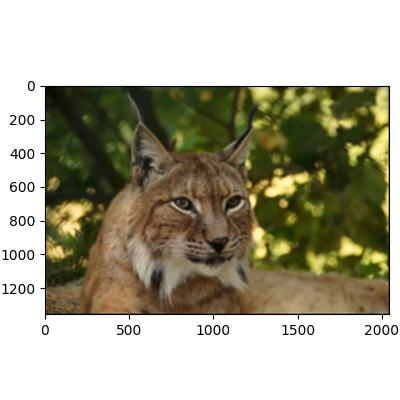
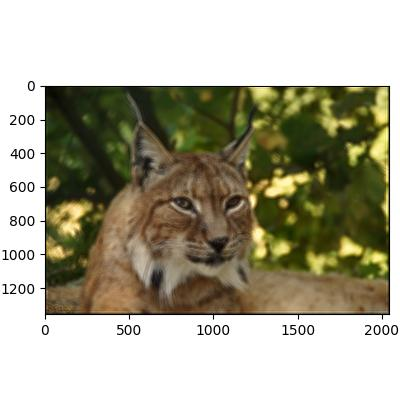

In [4]:
# 시뮬레이션 수행 및 결과 시각화
# tt.simulate: 이미지를 특정 거리로 전파하는 시뮬레이션을 수행
# timg: 입력 이미지
# 0, 10e-3, 20e-3: 전파 거리 (0m, 10mm, 20mm)
# figsize: 출력 이미지 크기 설정
tt.show(tt.simulate(timg, 0), figsize=(4,4)) # 전파 거리 0m
tt.show(tt.simulate(timg, 10e-3), figsize=(4,4)) # 전파 거리 10mm
tt.show(tt.simulate(timg, 20e-3), figsize=(4,4)) # 전파 거리 20mm

In [5]:
import torch.nn as nn
import torch

# 입력 필드(field) 초기화
field = timg.clone() # 이미지 텐서를 복사하여 초기화
field.requires_grad = True # 필드를 학습 가능하도록 설정

# Adam 최적화 알고리즘 설정
optimizer = torch.optim.Adam([field], lr=0.0001) # 학습률 0.0001

# 손실 함수로 MSE(평균 제곱 오차) 사용
criterion = torch.nn.MSELoss()

# 최적화 반복 수행
for i in range(1000):
    """
    손실 함수 정의.
    field: 입력 필드
    z: 전파 거리
    timg: 타겟 이미지
    """
    optimizer.zero_grad() # 그래디언트를 초기화
    ## loss function
    sim = tt.simulate(field, 20e-3,).abs()**2 # 시뮬레이션 수행 후 강도 계산
    loss = criterion(sim, timg) # 시뮬레이션 결과와 원본 이미지 간의 손실 계산
    loss.backward()  # 손실에 대한 그래디언트를 계산

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


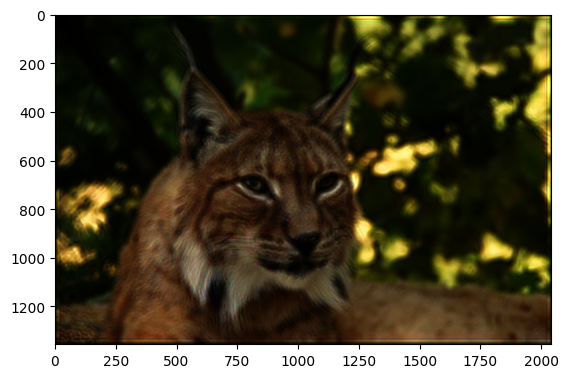

{'wl': (6.38e-07, 5.15e-07, 4.5e-07), 'dx': (6.3e-06, 6.3e-06)}

In [6]:
tt.simulate(field, 20e-3,).abs()**2 # 최적화된 필드를 시뮬레이션하고 결과를 강도로 변환

In [7]:
import torch.nn as nn # 신경망 관련 모듈
import torch
import torch.nn.functional as F 
def loss_func(field, z, timg):
    sim = tt.simulate(field, z,).abs()**2 # 시뮬레이션 수행 후 강도 계산
    loss = F.mse_loss(sim, timg) # 시뮬레이션 결과와 타겟 이미지 간의 손실 계산
    return loss

field = timg.clone() # 이미지 텐서를 복사하여 초기화

# tt.optimizer를 사용한 최적화 수행
# field: 초기 필드
# loss_func: 손실 함수
# 20e-3: 전파 거리
# timg: 타겟 이미지
r = tt.optimizer(field, loss_func, 20e-3, timg)

0.0006152791320346296: 100%|██████████| 500/500 [00:06<00:00, 81.33it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


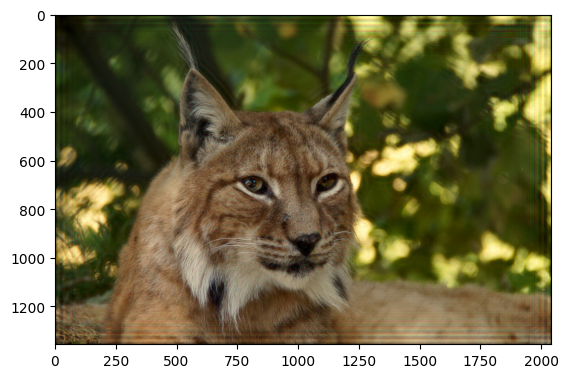

{'wl': (6.38e-07, 5.15e-07, 4.5e-07), 'dx': (6.3e-06, 6.3e-06)}

In [8]:
# 최적화된 필드를 시뮬레이션하고 결과를 강도로 변환
tt.simulate(r[0], 20e-3,).abs()**2